# Lab 3: Geostatistical simulation

## Your name here: Jake Ross

In this lab, you will compute the variogram for your radar topography measurements, which describes its roughness. 

Refer to the Scikit-Gstat and GStatSim Jupyter Book tutorials for guidance: 

https://gatorglaciology.github.io/gstatsimbook/intro.html 

https://scikit-gstat.readthedocs.io/en/latest/

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import skgstat as skg
from sklearn.preprocessing import QuantileTransformer
from mpl_toolkits.axes_grid1 import make_axes_locatable
import gstatsim as gs

### First, load your radar data from Lab 1. 

If you did not save a csv file with your radar bed measurements, you can do that by re-running the radar data cropping section in Lab 1 and saving a csv file. Alternatively, you can load and crop the radar data here using your domain coordinates. 

Remember, you will need to save the bed elevation, not ice thickness, by subtracting thickness from the ice surface. In Lab1, this was done in this line: df['bed'] = df['surf'].values - radar_thickness.flatten()

So save a csv with df['bed'] and the coordinates.

Make sure to drop any rows with NaN values. You can do that with df = df.dropna()

In [2]:
df_bed = pd.read_csv('../../OneDrive/DEMOGORGN_data/NinnisGlacierDataGridded.csv')
df_bed.head()

,x,y,surf,bed,velx,vely,smb,dhdt,highvel_mask,bedmap_mask,bedmap_surf,bedmachine_source,bedmachine_thickness,bedmap_bed
0,1182250,-2040750,426.0,NaN,39.483768,-87.782847,0.510333,0.101849,False,1.0,426.0,5.0,614.287170,-204.0
1,1182750,-2040750,422.0,NaN,43.552902,-85.604257,0.508544,0.092734,False,1.0,422.0,5.0,605.614807,-195.0
2,1183250,-2040750,411.0,NaN,46.854611,-84.212638,0.506756,0.084492,False,1.0,411.0,5.0,595.256775,-191.0
3,1183750,-2040750,395.0,NaN,45.391196,-83.165136,0.504968,0.075469,False,1.0,395.0,5.0,585.380554,-192.0
4,1184250,-2040750,380.0,NaN,41.183151,-79.336700,0.503180,0.059844,False,1.0,380.0,5.0,572.859406,-192.0


In [3]:
df_bed = df_bed[["x", "y", "bed"]]

In [4]:
df_bed = df_bed.dropna()
df_bed.head()

,x,y,bed
7,1185750,-2040750,-193.770
8,1186250,-2040750,-197.770
9,1186750,-2040750,-188.495
10,1187250,-2040750,-211.605
11,1187750,-2040750,-204.910


In [5]:
len(df_bed)

24687

Now let's plot your data. You'll want to change vmin and vmax to suit your data range.

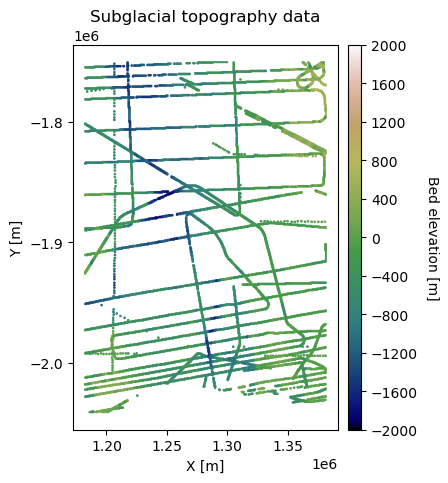

In [6]:
# plot data
fig = plt.figure(figsize = (5,5))
ax = plt.gca()
im = ax.scatter(df_bed['x'], df_bed['y'], c=df_bed['bed'], vmin=-2000, vmax=2000, 
                     marker='.', s=0.5, cmap='gist_earth')
plt.title('Subglacial topography data')
plt.xlabel('X [m]'); plt.ylabel('Y [m]')
plt.locator_params(nbins=5)
plt.axis('scaled')

# make colorbar
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.1)
cbar = plt.colorbar(im, ticks=np.linspace(-2000, 2000, 11), cax=cax)
cbar.set_label("Bed elevation [m]", rotation=270, labelpad=15)
plt.show()

### Normal score transformation

Geostatistical methods typically require Gaussian assumptions, so we need to perform a normal score transformation to convert to a standard Gaussian distribution (mean = 0, standard deviaton = 1, Gaussian shape). After performing a geostatistical interpolation, we will back-transform the interpolation to recover the original distribution.

In [7]:
# normal score transformation
data = df_bed['bed'].values.reshape(-1,1)
nst_trans = QuantileTransformer(n_quantiles=500, output_distribution='normal').fit(data)
df_bed['Nbed'] = nst_trans.transform(data) 

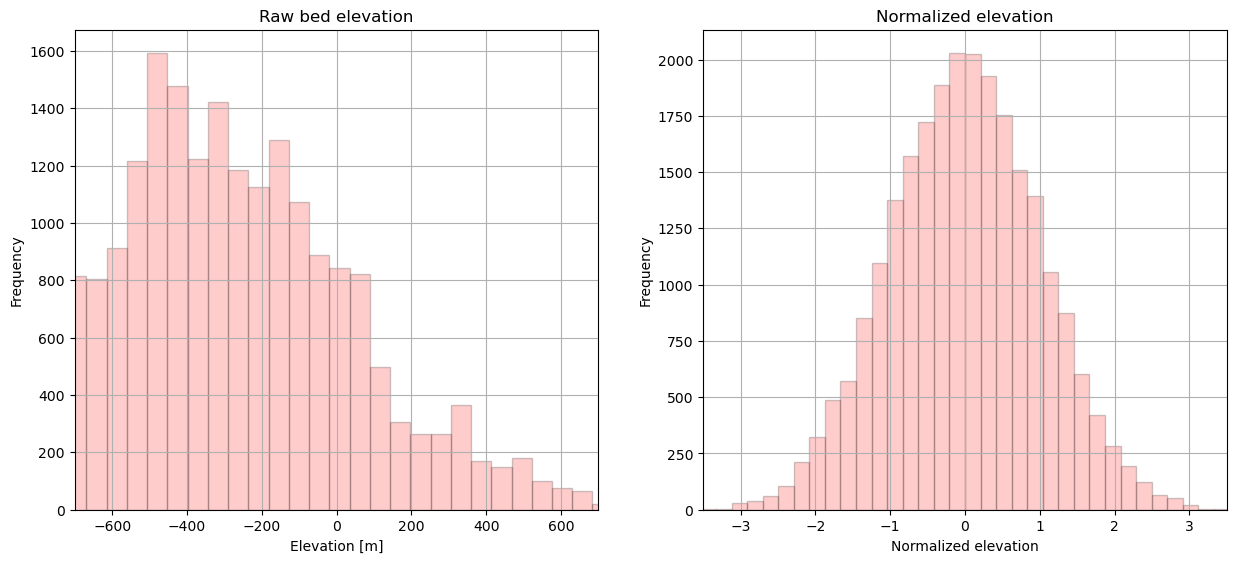

In [8]:
# plot original bed histogram
plt.subplot(121)
plt.hist(df_bed['bed'], facecolor='red', bins=50, alpha=0.2, edgecolor='black')
plt.xlim([-700,700]); 
plt.xlabel('Elevation [m]'); plt.ylabel('Frequency'); plt.title('Raw bed elevation')
plt.grid(True)

# plot normal score bed histogram (with weights)
plt.subplot(122)
plt.hist(df_bed['Nbed'], facecolor='red', bins=50, alpha=0.2, edgecolor='black')
plt.xlim([-3.5,3.5]); 
plt.xlabel('Normalized elevation'); plt.ylabel('Frequency'); plt.title('Normalized elevation')
plt.grid(True)
plt.subplots_adjust(left=0.0, bottom=0.0, right=1.8, top=1.0, wspace=0.2, hspace=0.3)
plt.show()

__Q1: How do the before and after transformation histograms compare? Why is this step important?__

Answer: Before the normalization was performed, the elevation was shifted more to the left, meaning most of the bed elevation is below 0 m 

### Compute the experimental variogram

The variogram is how we "learn" the roughness of the topography.

When computing the variogram, we'll randomly drop out a fraction of the points to speed up the variogram calculation. Don't worry, the variogram will still be fairly robust. You might need to play around with this percentage, depending on how much data you have.

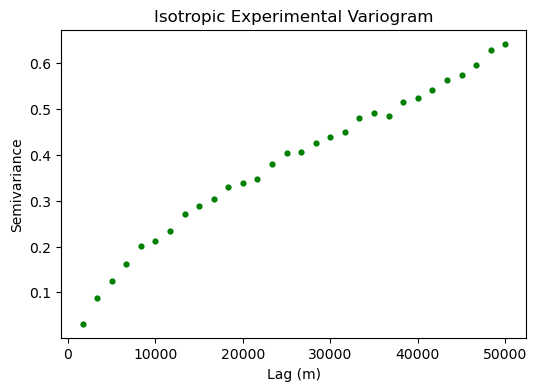

In [9]:
# randomly drop out 50% of coordinates. Decrease this value if you have a lot of data and it takes a long time to run
df_sampled = df_bed.sample(frac=0.5, random_state=42)

# compute experimental (isotropic) variogram
coords = df_sampled[['x','y']].values
values = df_sampled['Nbed']

maxlag = 50000      # maximum range distance
n_lags = 30         # num of bins (try decreasing if this is taking too long)

# compute variogram
V1 = skg.Variogram(coords, values, bin_func='even', n_lags=n_lags, maxlag=maxlag, normalize=False)

# extract variogram values
xdata = V1.bins
ydata = V1.experimental

plt.figure(figsize=(6,4))
plt.scatter(xdata, ydata, s=12, c='g')
plt.title('Isotropic Experimental Variogram')
plt.xlabel('Lag (m)'); plt.ylabel('Semivariance')
plt.show()

In [10]:
df_sampled.head

<bound method NDFrame.head of               x        y       bed      Nbed
230094  1229250 -1753250 -1228.300 -1.522535
60177   1270750 -1965750  -147.850  0.626345
60072   1218250 -1965750  -413.760 -0.045157
30563   1263750 -2002750  -325.515  0.169170
81088   1326250 -1939750   -41.950  0.922848
...         ...      ...       ...       ...
209303  1233750 -1779250 -1547.900 -2.270585
35408   1286250 -1996750 -1245.465 -1.556449
229233  1198750 -1754250 -1183.900 -1.418793
37873   1318750 -1993750  -770.780 -0.861641
119095  1329750 -1892250  -362.140  0.079350

[12344 rows x 4 columns]>

__Q2: By looking at your variogram model, roughly what is your sill and range? What do these parameters represent? Why does the semivariance axis go up to ~1?__

Answer: The sill is around 0.9, and the range is around 80-100 km. The sill is the variance at which the system reaches its maximum. The range is the lag distance at which the points are no longer correlated to the initial point.

### Fit variogram model

Now we need to fit variogram model parameters to the experimental variogram. We will use these model parameters when we perform our simulations.

There are many different variogram model types. We will use the Matern variogram because it has an extra parameter which helps the model fit extra well, and I think this model type tends to produce the most believable looking topography.

Read up on variogram modeling here: https://scikit-gstat.readthedocs.io/en/latest/auto_examples/tutorial_03_variogram_models.html#sphx-glr-auto-examples-tutorial-03-variogram-models-py 

In [11]:
# use matern variogram model
V1.model = 'matern' 
V1.parameters

[49999.9999999993, 0.5873486317928017, 0.8042054116538399, 0]

__Q3: Describe each parameter? How does this compare to your guess in Q2?__

Answer: the range is nearly 100,000, which is in the range of what I predicted. The sill is right at my prediction of 0.9. My smoothness is at 0.79, which is moderately smooth. The nugget is 0, which is what we want 

In [12]:
# evaluate models
xi =np.linspace(0, xdata[-1], 100) 

y_matern = skg.models.matern(xi, V1.parameters[0], V1.parameters[1], V1.parameters[2], V1.parameters[3])


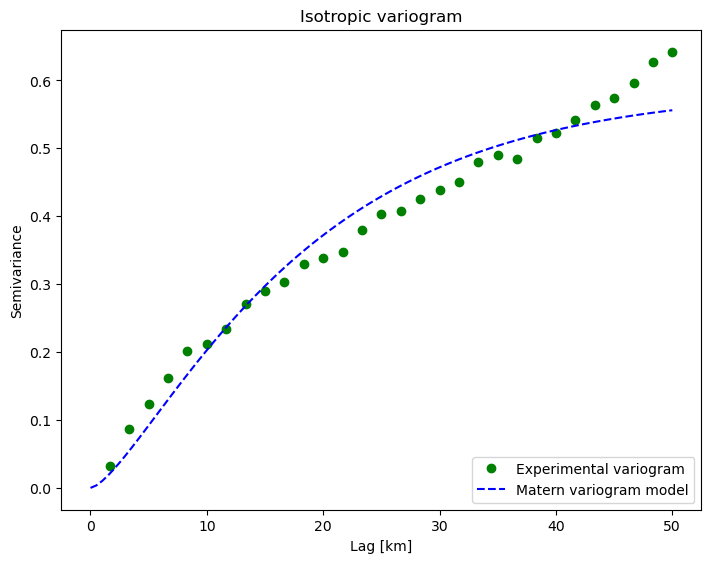

In [13]:
# plot variogram model
fig = plt.figure()
plt.plot(xdata/1000,ydata,'og', label = "Experimental variogram")
plt.plot(xi/1000, y_matern,'b--', label='Matern variogram model')
plt.title('Isotropic variogram')
plt.xlabel('Lag [km]'); plt.ylabel('Semivariance')  
plt.subplots_adjust(left=0.0, bottom=0.0, right=1, top=1.0) # adjust the plot size
plt.legend(loc='lower right')

### Now that we have our variogram parameters, we can move on to simulation

First, we need to initialize a simulation grid. This will ensure your data is properly gridded. 

In [14]:
# grid data to 500 m resolution and remove coordinates with NaNs
res = 2000
df_grid, grid_matrix, rows, cols = gs.Gridding.grid_data(df_bed, 'x', 'y', 'Nbed', res)
df_grid = df_grid[df_grid["Z"].isnull() == False]
df_grid = df_grid.rename(columns = {"Z": "Nbed"}) # rename last column

# define coordinate grid
xmin = np.min(df_grid['X']); xmax = np.max(df_grid['X'])     # min and max x values
ymin = np.min(df_grid['Y']); ymax = np.max(df_grid['Y'])     # min and max y values

pred_grid = gs.Gridding.prediction_grid(xmin, xmax, ymin, ymax, res)

In [15]:
df_grid.head()

,X,Y,Sum,Count,Nbed
2,1186250.0,-2040750.0,2.729652,6.0,0.454942
3,1188250.0,-2040750.0,1.800056,7.0,0.257151
4,1190250.0,-2040750.0,3.576015,6.0,0.596002
5,1192250.0,-2040750.0,12.199063,8.0,1.524883
6,1194250.0,-2040750.0,16.570863,10.0,1.657086


Let's set up our simulation. We'll need the variogram parameters, and we als oneed to decide our number of nearest neighboring conditioning points and search radius.

In [16]:
# save variogram parameters as a list
azimuth = 0
nugget = 0 # make nugget 0

# the major and minor ranges are the same in this example because it is isotropic
major_range = V1.parameters[0]
minor_range = V1.parameters[0]
sill = V1.parameters[1]
smoothness = V1.parameters[2]
vtype = 'matern'
vario_list = [azimuth, nugget, major_range, minor_range, sill, 'matern', smoothness]

k = 48         # number of neighboring data points used to estimate a given point 
rad = 70000    # 70 km search radius

sim = gs.Interpolation.okrige_sgs(pred_grid, df_grid, 'X', 'Y', 'Nbed', k, vario_list, rad, quiet=False, seed=0)
sim_trans = nst_trans.inverse_transform(sim.reshape(-1,1)).squeeze() # back transformation

100%|███████████████████████████████████████████████████████████████████████████| 14500/14500 [01:53<00:00, 128.12it/s]


This might take a while! While you are working on the code, you might want to temporarily coarsen the resolution to save time.

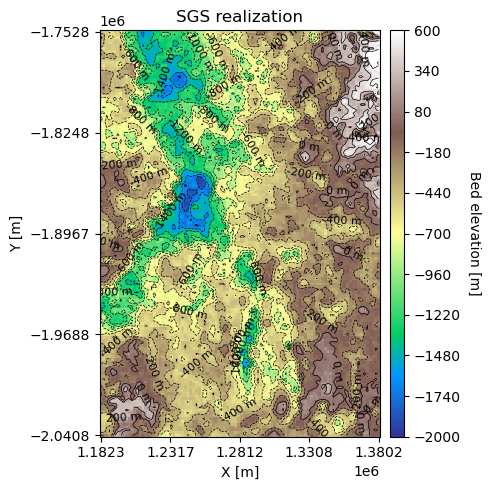

In [20]:
# plot simulation
x_mat = pred_grid[:,0].reshape((rows, cols))
y_mat = pred_grid[:,1].reshape((rows, cols))
sgs_mat = sim_trans.reshape((rows, cols))

fig, ax = plt.subplots(figsize=(6, 5))

im = ax.pcolormesh(x_mat, y_mat, sgs_mat, vmin=-2000, vmax=600, cmap='terrain')
ax.set_title('SGS realization')
ax.set_xlabel('X [m]')
ax.set_ylabel('Y [m]')

ax.set_xticks(np.linspace(xmin, xmax, 5))
ax.set_yticks(np.linspace(ymin, ymax, 5))

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.1)
cbar = plt.colorbar(im, ticks=np.linspace(-2000, 600, 11), cax=cax)
cbar.set_label("Bed elevation [m]", rotation=270, labelpad=15)

contours = ax.contour(x_mat, y_mat, sgs_mat, 
                      levels=np.arange(-2000, 601, 200),  # contour interval every 200 m
                      colors='k', linewidths=0.5)
ax.clabel(contours, inline=True, fontsize=8, fmt=lambda x: f"{int(x)} m")

ax.axis('scaled')

plt.tight_layout()
plt.show()
fig.savefig('sgs_realization')

Load in your BedMachine data and plot the topography for this region.

In [19]:
df = pd.read_csv('../../OneDrive/DEMOGORGN_data/NinnisGlacierDataGridded.csv')
xx, yy = np.meshgrid(np.unique(df.x), np.unique(df.y))

In [20]:
surf = df['surf'].values.reshape(xx.shape)
bedmachine_thickness = df['bedmachine_thickness'].values.reshape(xx.shape)
bm_topography = surf - bedmachine_thickness

In [21]:
df.columns

Index(['x', 'y', 'surf', 'bed', 'velx', 'vely', 'smb', 'dhdt', 'highvel_mask',
       'bedmap_mask', 'bedmap_surf', 'bedmachine_source',
       'bedmachine_thickness', 'bedmap_bed'],
      dtype='object')

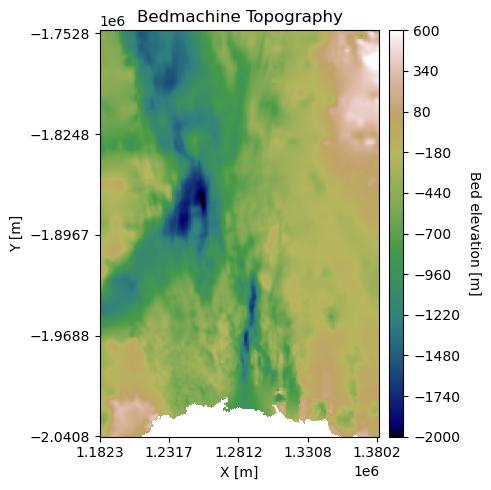

In [22]:
fig, ax = plt.subplots(figsize=(6, 5))

im = ax.pcolormesh(xx, yy, bm_topography, vmin=-2000, vmax=600, cmap='gist_earth')
ax.set_title('Bedmachine Topography')
ax.set_xlabel('X [m]')
ax.set_ylabel('Y [m]')

ax.set_xticks(np.linspace(xmin, xmax, 5))
ax.set_yticks(np.linspace(ymin, ymax, 5))

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.1)
cbar = plt.colorbar(im, ticks=np.linspace(-2000, 600, 11), cax=cax)
cbar.set_label("Bed elevation [m]", rotation=270, labelpad=15)

ax.axis('scaled')

plt.tight_layout()
plt.show()

__Q4: Visually, how does your simulated topography compare to BedMachine? Why do they differ?__

Answer: My simulated topography has a similar general structure, but bedmachine looks a little bit rougher and my simulation is more continuous. This could be due to me having to change the resolution from the recommended 500 to 2000 so it would run without taking up all my memory. Also my simulation has more diagonal lines of low elevation, but bedmachine is a little bit more vertical.  

## Variogram comparison

Now you are going to compare the variograms for BedMachine and your simulation. Compute the experimental variograms for both BedMachine and your simulated (back-transformed) topography. Plot the two experimental variograms.

In [23]:
df['bm_topography'] = bm_topography.flatten()

In [24]:
df.columns

Index(['x', 'y', 'surf', 'bed', 'velx', 'vely', 'smb', 'dhdt', 'highvel_mask',
       'bedmap_mask', 'bedmap_surf', 'bedmachine_source',
       'bedmachine_thickness', 'bedmap_bed', 'bm_topography'],
      dtype='object')

In [25]:
print(df['bm_topography'].count())

print(df['x'].count())
print(df['y'].count())

223655
232400
232400


In [26]:
df_clean = df.dropna(subset=['x', 'y', 'bm_topography', 'bed'])
#print(len(df_clean))
print(df_clean['bed'].count())
print(df_clean['bm_topography'].count())
print(df_clean['x'].count())
print(df_clean['y'].count())

24687
24687
24687
24687


In [21]:
# normal score transformation
#data = df_clean['bed'].values.reshape(-1,1)
#nst_trans = QuantileTransformer(n_quantiles=500, output_distribution='normal').fit(data)
#df_clean['bm_topography'] = nst_trans.transform(data) 

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


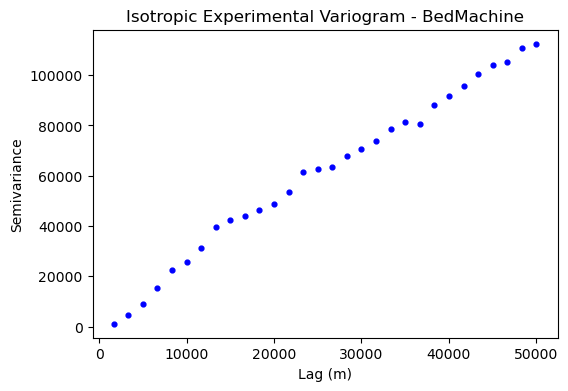

In [27]:
####### Your code here ############
df_sampled = df_clean.sample(frac=0.1, random_state=42)

# Extract coordinates and values
coords = df_sampled[['x','y']].values
values = df_sampled['bm_topography']
df_sampled.head()
# Variogram parameters
maxlag = 50000   # meters
n_lags = 30

# Compute experimental isotropic variogram
V_bedmachine = skg.Variogram(coords, values, bin_func='even', n_lags=n_lags, maxlag=maxlag, normalize=False)

# Extract variogram data
xdata_bm = V_bedmachine.bins
ydata_bm = V_bedmachine.experimental

# Plot
plt.figure(figsize=(6,4))
plt.scatter(xdata_bm, ydata_bm, s=12, c='b')
plt.title('Isotropic Experimental Variogram - BedMachine')
plt.xlabel('Lag (m)')
plt.ylabel('Semivariance')
plt.show()

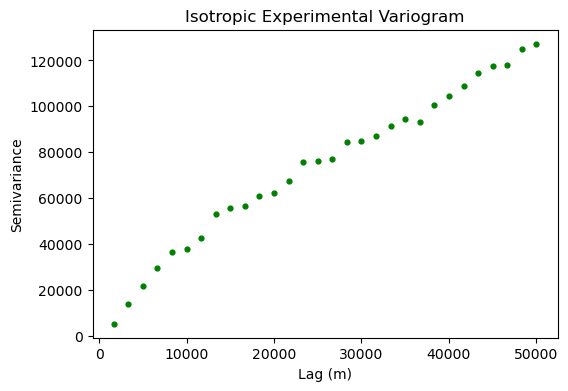

In [29]:
# randomly drop out 50% of coordinates. Decrease this value if you have a lot of data and it takes a long time to run
df_sampled = df_clean.sample(frac=0.1, random_state=42)

# compute experimental (isotropic) variogram
coords = df_sampled[['x','y']].values
values = df_sampled['bed']

maxlag = 50000      # maximum range distance
n_lags = 30         # num of bins (try decreasing if this is taking too long)

# compute variogram
V1 = skg.Variogram(coords, values, bin_func='even', n_lags=n_lags, maxlag=maxlag, normalize=False)

# extract variogram values
xdata = V1.bins
ydata = V1.experimental

plt.figure(figsize=(6,4))
plt.scatter(xdata, ydata, s=12, c='g')
plt.title('Isotropic Experimental Variogram')
plt.xlabel('Lag (m)'); plt.ylabel('Semivariance')
plt.show()

In [30]:
df_new = pd.DataFrame(columns=['x_mat', 'y_mat', 'sgs_mat', 'bed'])
df_new['sgs_mat'] = sgs_mat.flatten()
df_new['x_mat'] = x_mat.flatten()
df_new['y_mat'] = y_mat.flatten()
df_new['bed'] = sgs_mat.flatten()
#df_new['bed'] = y_mat.flatten()

print(df_new)

           x_mat      y_mat     sgs_mat         bed
0      1182250.0 -1752750.0 -491.413418 -491.413418
1      1184250.0 -1752750.0 -493.452596 -493.452596
2      1186250.0 -1752750.0 -523.336690 -523.336690
3      1188250.0 -1752750.0 -647.678750 -647.678750
4      1190250.0 -1752750.0 -574.114580 -574.114580
...          ...        ...         ...         ...
14495  1372250.0 -2040750.0  119.020994  119.020994
14496  1374250.0 -2040750.0  -21.687903  -21.687903
14497  1376250.0 -2040750.0  -35.879821  -35.879821
14498  1378250.0 -2040750.0  -73.799186  -73.799186
14499  1380250.0 -2040750.0  -73.514866  -73.514866

[14500 rows x 4 columns]


In [25]:
# normal score transformation
#data = df_new['bed'].values.reshape(-1,1)
#nst_trans = QuantileTransformer(n_quantiles=500, output_distribution='normal').fit(data)
#df_new['sgs_mat'] = nst_trans.transform(data) 

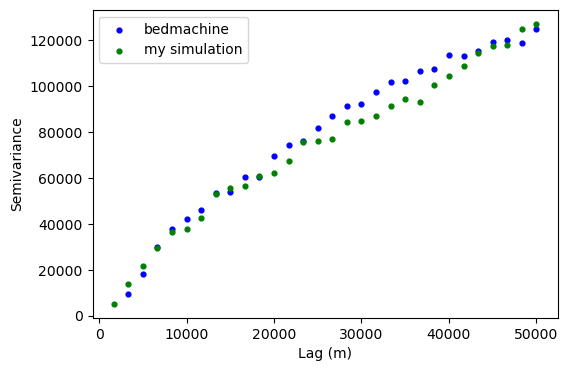

In [37]:
df_sampled = df_new.sample(frac=0.1, random_state=42)

# Extract coordinates and values
coords = df_sampled[['x_mat','y_mat']].values
values = df_sampled['sgs_mat']

# Variogram parameters
maxlag = 50000   # meters
n_lags = 30

# Compute experimental isotropic variogram
V_bedmachine = skg.Variogram(coords, values, bin_func='even', n_lags=n_lags, maxlag=maxlag, normalize=False)

# Extract variogram data
xdata_bm = V_bedmachine.bins
ydata_bm = V_bedmachine.experimental

# Plot
plt.figure(figsize=(6,4))
plt.scatter(xdata_bm, ydata_bm, s=12, c='b', label = "bedmachine")
#plt.title('Isotropic Experimental Variogram - my simulation')
#plt.xlabel('Lag (m)')
#plt.ylabel('Semivariance')

#plt.figure(figsize=(6,4))
plt.scatter(xdata, ydata, s=12, c='g', label = "my simulation")
#plt.title('Isotropic Experimental Variogram')
plt.xlabel('Lag (m)'); plt.ylabel('Semivariance')
plt.legend()
plt.show()

In [32]:
sgs_bed = nst_trans.inverse_transform(sim.reshape(-1,1)).reshape(xx.shape)
np.savetxt('sgs_bed.txt',sgs_bed)

ValueError: cannot reshape array of size 14500 into shape (581,400)

__Q5: How do the experimental variograms differ? How do you interpret these differences?__

Answer: The experimental variogram from my SGS simulation shows lower semivariance and a more linear increase compared to the BedMachine variogram. This suggests my simulation is smoother, with stronger spatial continuity and less small-scale variability than the observed data.